<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/Sampling_testcode%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### library

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import json

### G Drive mount

In [2]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


### Initial Checker

In [3]:
class InitialChecker():
    def __init__(self, model, train, live, drop_cols, y):
        self.model = model
        self._Xtrain = train.drop(columns=drop_cols).values
        self._ytrain = train[y].values
        self.live = live
        self.drop_cols = drop_cols
        self.y = y


    def check_drift(self, drift_checkers):
        Xlive = self.live.drop(columns=self.drop_cols).values
        drift_value = np.array([dc(Xlive, self._Xtrain, self.model) for dc in drift_checkers])
        df_drift = {}
        for i, dc in enumerate(drift_checkers):
            df_drift["%s"%dc.__name__] = drift_value[i]
        return df_drift

### Multi-Variate Sampler

In [4]:
class MVSampler():
    def __init__(self, reference, inference, target_cols):
        """
        reference : pd.DataFrame. 모집단으로 사용될 set.(test를 넣으면 됨)
        inference : pd.DataFrame. 배경집단으로 사용된 inference set
        target_cols : array-like. 해당 column들에 대해서만 확률 계산
        """
        self._pdf = {}
        self._cnt = np.zeros(reference.shape[0])
        self.reference = reference.copy()
        del reference
        self.inference = inference.copy()
        del inference
        self.target_cols = target_cols

        bins = int(1+3.322*np.log10(self.inference.shape[0]))
        for col in self.target_cols:
            p, bin_edge = np.histogram(self.inference[col].values,
                                       bins=np.min([bins, len(self.inference[col].unique())]),
                                       density=True)
            self._pdf[col] = (p, bin_edge)

        for col in self.target_cols:
            bin_edge = self._pdf[col][1]
            b = (bin_edge[1:] + bin_edge[:-1])/2
            lcond = self.reference[col].values>=b.min()
            rcond = self.reference[col].values<=b.max()
            self._cnt += (lcond*rcond*1)

    def build(self, row_min = -1, outlier = 0):
        """
        row_min : int. sampling에 사용될 reference의 최소 row 갯수
        outlier : int. ref/inf 의 target_col 분포를 비교할 때, 고려하지 않을 column의 갯수
        모든 target_col이 ref/inf 분포가 겹치지 않을 수 있기 때문에 일정 row 갯수가 확보될 때 까지 증가
        """
        if row_min  < 0:
            row_min = int(self.inference.shape[0] * 0.1)

        nsize = len(np.where(self._cnt>=len(self.target_cols)-outlier)[0])
        while (nsize <= row_min) and (outlier <= len(self.target_cols)):
            outlier += 1
            nsize = len(np.where(self._cnt>=len(self.target_cols)-outlier)[0])
        self._outlier = outlier

        self.likelihood = np.zeros(self.reference.shape[0])
        for i in range(self.reference.shape[0]):
            row_vector = self.reference.iloc[i, :]
            if self._cnt[i]>=len(self.target_cols)-outlier:
                p = np.array([self.interp_pdf(self._pdf[col], row_vector[col]) for col in self.target_cols])
                self.likelihood[i] = np.power(10, np.sum(np.log10(p[np.where(p!=0)[0]])))

    @staticmethod
    def interp_pdf(pdf, x):
        p, bin_edge = pdf
        b = (bin_edge[1:] + bin_edge[:-1])/2
        if x<=b.min() or x>=b.max():
            return 0
        f = interp1d(b, p, kind="linear")
        y = f(x)
        return y

    def sample(self, n=-1, seed=None, return_index=False):
        """
        n : int. sample의 크기
        return_index : bool. True일 경우 sample의 index를 array로 return, False일 경우 sample을 pd.DataFrame으로 return. 기본은 False
        return : pd.DataFrame / array-like
        """
        n = n if n>0 else self.inference.shape[0]//10
        prob = self.likelihood #np.power(10, self.log_likelihood)
        prob /= np.sum(prob)
        rng = np.random.default_rng(seed)
        idx = rng.choice(np.arange(0, self.reference.shape[0]), replace=True, p=prob, size=n)
        if return_index:
            return idx
        return self.reference.iloc[idx, :]

### Sample Analyzer

In [5]:
class SampleAnalyzer():
    def __init__(self, model, train, sample,drop_cols, y):
        """
        train : pd.DataFrame.
        drift_detectors : array-like. drift value계산을 위한 function point. ex)ks_drift_checker(ref, live, model)
        target_cols : array-like. 해당 column들에 대해서만 확률 계산
        drop_cols : array-like. X domain에서 제외해야할 column. ex) loan_data : [loan_paid, time]
        """
        self.model = model
        self._Xtrain = train.drop(columns = drop_cols).values
        self.sample = sample
        self.drop_cols = drop_cols
        self.y = y

    def check_drift(self, drift_checkers):
        drift_value = []
        for sample in self.sample:
            Xsmp = sample.drop(columns=self.drop_cols).values
            dvs = np.array([dc(Xsmp, self._Xtrain, self.model) for dc in drift_checkers])
            drift_value.append(dvs)
        drift_value= np.array(drift_value)

        df_drift = {}
        for i, dc in enumerate(drift_checkers):
            df_drift["%s"%dc.__name__] = drift_value[:, i]
        return df_drift

    def check_metric(self, metrics):
        df_metric = {}
        samples = [(sample.drop(columns=self.drop_cols).values, sample[self.y].values) for sample in self.sample]

        for metric in metrics:
            metric_name = metric.__name__
            df_metric[metric_name] = np.zeros(len(samples))
            for i, (Xsmp, ysmp) in enumerate(samples):
                df_metric[metric_name][i] = metric(self.model, Xsmp, ysmp)
        return df_metric

### Performance Estimator

In [6]:
def dist(slope, intercept, x, y):
    return abs(slope*x-y+intercept)/np.sqrt(slope**2+1)
def linear(x, a, b):
    return a*x+b
def chi2(slope, intercept, x, y):
    dobs = dist(slope, intercept, x, y)**2
    return np.sum(dobs)/ 2 / (len(x)-2)


class PerformanceEstimator():
    def __init__(self, drift, drift_smp, metric_smp):
        self.drift = drift
        self.drift_smp = drift_smp
        self.metric_smp = metric_smp

    def estimate(self, n = 5):
        drift_list = self.drift_smp.keys()
        metric_list = self.metric_smp.keys()
        if len(self.drift[list(self.drift.keys())[0]])<n:
            return self.metric_smp

        metric_est = {}
        for key, m in self.metric_smp.items():
            metric_est[key] = self.correction(metric= m, drift =self.drift, drift_smp = self.drift_smp)
        return metric_est

    @staticmethod
    def nlinearfit(x, y, th = 2):
        x = np.array(x) if isinstance(x, list) else x
        y = np.array(y) if isinstance(y, list) else y
        m = (y.max() - y.min()) / (x.min() - x.max())
        i = y.mean() - m * x.mean()
        d, c2 = dist(m, i, x, y), chi2(m, i, x, y)
        cnt = 0

        while c2>th and m>0 and cnt<len(x)-4:
            xn, yn = x[np.argsort(d)[:len(x)-cnt]], y[np.argsort(d)[:len(x)-cnt]]
            popt, _ = curve_fit(linear, xn, yn)
            m, i = popt[0], popt[1]
            c2 = chi2(m, i, xn, yn)
            cnt += 1
        c2 = chi2(m, i, x, y)
        return m, i, c2

    @staticmethod
    def correction(metric, drift, drift_smp):
        metric_cor = 0
        denominator = 0

        for k in drift_smp.keys():
            d, d_smp =  drift[k], drift_smp[k]
            dbar = d[-1] - np.min(d)
            dbar_smp = d_smp - np.min(d_smp)
            r1, beta, chi2 = PerformanceEstimator.nlinearfit(dbar_smp, metric, 1.6)
            metric_cor += (r1 * dbar + beta) / chi2
            denominator +=  (1/chi2)

        return metric_cor/denominator

### Metric & drift checker (Temporal)

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
def accuracy(model, X, y):
    return accuracy_score(model.predict(X), y)*100

def f1(model, X, y):
    return f1_score(model.predict(X), y) *100

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def D3(reference, inference, model):
    y1 = np.zeros(reference.shape[0]).reshape(-1, 1)
    y2 = np.ones(inference.shape[0]).reshape(-1, 1)
    X = np.vstack((reference, inference))
    y = np.vstack((y1, y2))
    lr = LogisticRegression(solver="lbfgs", random_state=0, max_iter=5000).fit(X, y.ravel())
    return roc_auc_score(y, lr.predict_proba(X)[:, 1])

from scipy.stats import ks_2samp, entropy
def uncertainty(reference, inference, model):
    entropy_ref = entropy(model.predict_proba(reference), axis = -1)
    entropy_inf = entropy(model.predict_proba(inference), axis = -1)
    d, p = ks_2samp(entropy_ref, entropy_inf)
    return d

from scipy.linalg import sqrtm
def FID(reference, inference, model):
    act_ref, act_inf = [], []

    for i in range(reference.shape[0]):
        refr, infr = reference[i, :], inference[i, :]
        vmin, vmax = min(refr.min(), infr.min()), max(refr.max(), infr.max())
        bins = int(1+3.322*np.log10(max(len(refr), len(infr))))
        refh, _ = np.histogram(refr, range=(vmin, vmax), bins=bins)
        infh, _ = np.histogram(infr, range=(vmin, vmax), bins=bins)
        act_ref.append(refh)
        act_inf.append(infh)

    act_ref = np.array(act_ref)
    act_inf = np.array(act_inf)
    mu1, sigma1 = np.mean(act_ref, axis=0), np.cov(act_ref, rowvar=False)
    mu2, sigma2 = np.mean(act_inf, axis=0), np.cov(act_inf, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    mat_dot = sigma1.dot(sigma2)
    covmean = sqrtm(mat_dot)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


### Preparation

In [8]:
### READ FILES ###
rdir =  "/content/drive/MyDrive/Drift/02"
df = pd.read_csv(rdir+".csv", index_col = 0)
infos = json.load(open(rdir+".json"))

### Reference =split into=> train/test ###
tcut = (3*infos["time_range"][0]+infos["drift_time"][0])/4
reference = df[df.time < tcut]
df_train = reference[reference.time < reference.time.mean()]
df_test = reference[reference.time >= reference.time.mean()]

### Inference =split into=> indiv live set ###
inference = df[df.time >= tcut]
dt = 30
tmin, tmax = inference.time.min(), inference.time.max()
# live_set : inference를 쪼개서 list로 구성(for 문 돌리는데 사용할 예정)
live_set = [inference[(inference.time>tmin+dt*i)&(inference.time<=tmin+dt*(i+1))] for i in range(int((tmax-tmin)//dt))]

### Target/Drop/Y columns ###
# target_cols : sampling 할 때 고려할 column list. feature importance 등을 사용하여 설정
# drop_cols : X domain에서 제외할 column명
# ylabel : y domain column명
target_cols = ["C%02d"%c if c<infos["n_cont"] else "D%02d"%(c-infos["n_cont"]) for c in infos["att_cols"]]
drop_cols = ["time", "drift", "y"]
ylabel = "y"


drift_checkers = [D3, uncertainty, FID]
metrics = [accuracy, f1]

### fit model ###
X_train = df_train.drop(columns=drop_cols).values
y_train = df_train[ylabel].values
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=6).fit(X_train, y_train)

### Define DB
DB = {}
for metric in metrics:
    DB[metric.__name__] = []
    DB[metric.__name__+"_smp"] = []
    DB[metric.__name__+"_est"] = []
for dc in drift_checkers:
    DB[dc.__name__] = []
    DB[dc.__name__+"_smp"] = []
DB["time"] = []


### TEST

In [9]:
from tqdm import tqdm

from time import time
t0 = time()

for live in tqdm(live_set[0:3]):
    tl = time()

    ### 1) Agent : live의 drift value 측정
    ic = InitialChecker(
        model = model,
        train = df_train,
        live = live,
        drop_cols= drop_cols,
        y = ylabel
        )
    drift0 = ic.check_drift(drift_checkers=drift_checkers)

    ### DB에 저장
    DB["time"].append(np.mean(live.index.values))
    for k, v in drift0.items():
        DB[k].append(v)


    ### 1-1)send <live> to Engine

    ### 2) Engine
    mvs = MVSampler(df_test, live, target_cols)
    mvs.build()
    sample = [mvs.sample(return_index=False) for _ in range(100)]

    ### 2-1) send <sample> to Agent

    ### 3) Agent ###
    sa = SampleAnalyzer(
        model = model,
        train = df_train,
        sample = sample,
        drop_cols = drop_cols,
        y = ylabel
        )

    drift = sa.check_drift(drift_checkers = drift_checkers)
    metric = sa.check_metric(metrics = metrics)
    ### DB에 저장
    for k, v in drift.items():
        DB[k+"_smp"].append(np.mean(v))
    for k, v in metric.items():
        DB[k+"_smp"].append(np.mean(v))

    ### DB에서 load
    DB_drift = {k:DB[k] for k in drift.keys()}
    DB_drift_smp = {k:DB[k+"_smp"] for k in drift.keys()}
    DB_metric_smp = {k:DB[k+"_smp"] for k in metric.keys()}

    pe = PerformanceEstimator(
        drift = DB_drift,
        drift_smp = DB_drift_smp,
        metric_smp = DB_metric_smp)

    metric_est = pe.estimate(n = 5)
    for k, v in metric_est.items():
        if isinstance(v, list):
            DB[k+"_est"].append(v[-1])
        else:
            DB[k+"_est"].append(v)

    for m in metrics:
        DB[m.__name__].append(m(model, live.drop(columns=drop_cols).values, live[ylabel].values))

    #print("%d"%np.mean(live.index.values), " : " ,"%d [sec]"%(time()-tl))
print("Total dT : %d : %d"%(divmod(time()-t0, 60)))

100%|██████████| 3/3 [02:41<00:00, 53.67s/it]

Total dT : 2 : 41


### Plot

In [10]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.colors import Normalize

R2 for accuracy :  -51.30114892623005
R2 for f1 :  -108.96880134456137


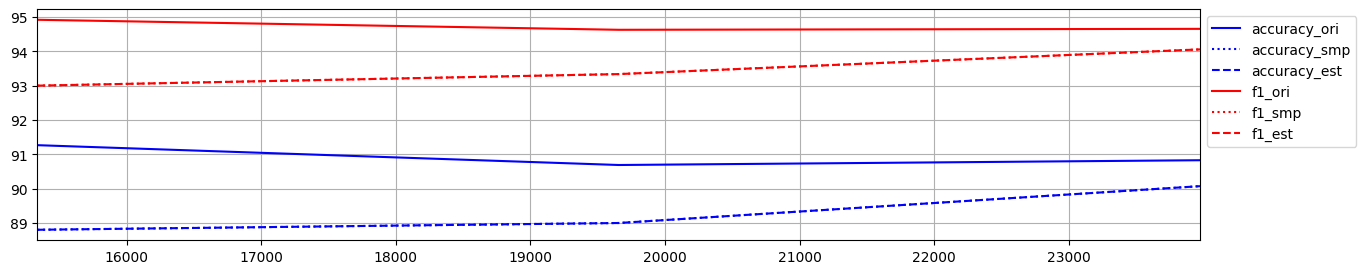

In [11]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
main_figsize=(15,3)
plt.figure(figsize=main_figsize)
color = ["b", "r" ,"k"]
for (c, m) in zip(color, metrics):
    name = m.__name__
    plt.plot(DB["time"], DB[name], label=name+'_ori', color=c)
    plt.plot(DB["time"], DB[name+"_smp"], label=name+"_smp", color=c, linestyle=":")
    plt.plot(DB["time"], DB[name+"_est"], label=name+"_est", color=c, linestyle="--")

    r2 = r2_score(DB[name],DB[name+"_est"])
    print(f'R2 for {name} : ', r2)

plt.xlim(min(DB["time"]), max(DB["time"]))
plt.grid()
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

### 검증용 함수

In [12]:
def PPM_Test(model,df_train,df_test,ylabel,live_set,target_cols,drop_cols):

    drift_checkers = [D3, uncertainty, FID]
    metrics = [accuracy, f1]

    ### Define DB
    DB = {}
    for mt in metrics:
        DB[mt.__name__] = []
        DB[mt.__name__+"_smp"] = []
        DB[mt.__name__+"_est"] = []
    for dc in drift_checkers:
        DB[dc.__name__] = []
        DB[dc.__name__+"_smp"] = []
    DB["time"] = []

    t0 = time()

    for live in tqdm(live_set):
        tl = time()

        ### 1) Agent : live의 drift value 측정
        ic = InitialChecker(
            model = model,
            train = df_train,
            live = live,
            drop_cols= drop_cols,
            y = ylabel
            )
        drift0 = ic.check_drift(drift_checkers=drift_checkers)

        ### DB에 저장
        DB["time"].append(np.mean(live.index.values))
        for k, v in drift0.items():
            DB[k].append(v)


        ### 1-1)send <live> to Engine

        ### 2) Engine
        mvs = MVSampler(df_test, live, target_cols)
        mvs.build()
        sample = [mvs.sample(return_index=False) for _ in range(100)]

        ### 2-1) send <sample> to Agent

        ### 3) Agent ###
        sa = SampleAnalyzer(
            model = model,
            train = df_train,
            sample = sample,
            drop_cols = drop_cols,
            y = ylabel
            )

        drift = sa.check_drift(drift_checkers = drift_checkers)
        metric = sa.check_metric(metrics = metrics)
        ### DB에 저장
        for k, v in drift.items():
            DB[k+"_smp"].append(np.mean(v))
        for k, v in metric.items():
            DB[k+"_smp"].append(np.mean(v))

        ### DB에서 load
        DB_drift = {k:DB[k] for k in drift.keys()}
        DB_drift_smp = {k:DB[k+"_smp"] for k in drift.keys()}
        DB_metric_smp = {k:DB[k+"_smp"] for k in metric.keys()}

        pe = PerformanceEstimator(
            drift = DB_drift,
            drift_smp = DB_drift_smp,
            metric_smp = DB_metric_smp)

        metric_est = pe.estimate(n = 5)
        for k, v in metric_est.items():
            if isinstance(v, list):
                DB[k+"_est"].append(v[-1])
            else:
                DB[k+"_est"].append(v)

        for m in metrics:
            DB[m.__name__].append(m(model, live.drop(columns=drop_cols).values, live[ylabel].values))

        #print("%d"%np.mean(live.index.values), " : " ,"%d [sec]"%(time()-tl))
    print("Total dT : %d : %d"%(divmod(time()-t0, 60)))

    plt.figure(figsize=main_figsize)
    color = ["b", "r" ,"k"]
    for (c, m) in zip(color, metrics):
        name = m.__name__
        plt.plot(DB["time"], DB[name], linewidth=1,label=name+'_ori', color=c)
        plt.plot(DB["time"], DB[name+"_smp"], linewidth=1,label=name+"_smp", color=c, linestyle=":")
        plt.plot(DB["time"], DB[name+"_est"], linewidth=1,label=name+"_est", color=c, linestyle="--")

        r2 = r2_score(DB[name],DB[name+"_est"])
        print(f'R2 for {name} : ', r2)

    plt.xlim(min(DB["time"]), max(DB["time"]))
    plt.grid()
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()


In [13]:
PPM_Test(model,df_train,df_test,ylabel,live_set,target_cols,drop_cols)

 24%|██▍       | 5/21 [04:25<14:09, 53.11s/it]


KeyboardInterrupt: ignored

# 검증 실험

## 준비 함수들...

In [14]:

import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import math

from torch.autograd import Variable
from argparse import Namespace
import warnings
warnings.filterwarnings("ignore")
import random
import os

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

main_figsize=(15,3)

def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [15]:

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


## Case #1 MI의 감소, Drift의 증가

In [16]:

data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

seed_everything()

y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)

seed_everything(100)

for i in range(400):
    s = i*100
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)

In [17]:

columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


Bucket size 200 step_size 190


100%|██████████| 190/190 [00:03<00:00, 58.72it/s]


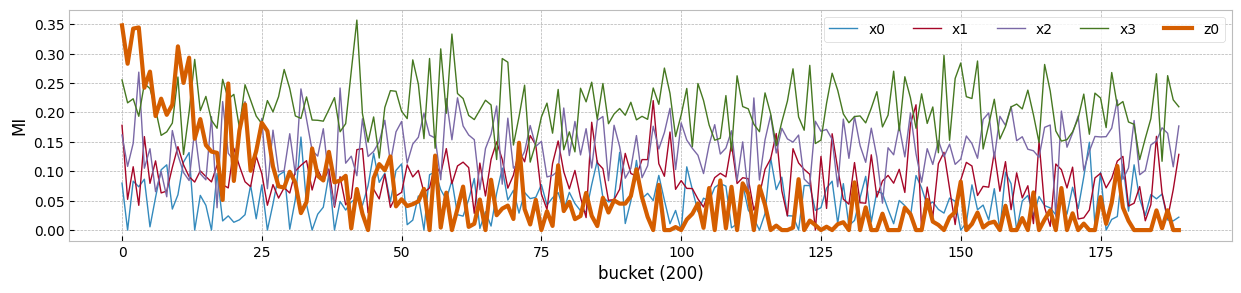

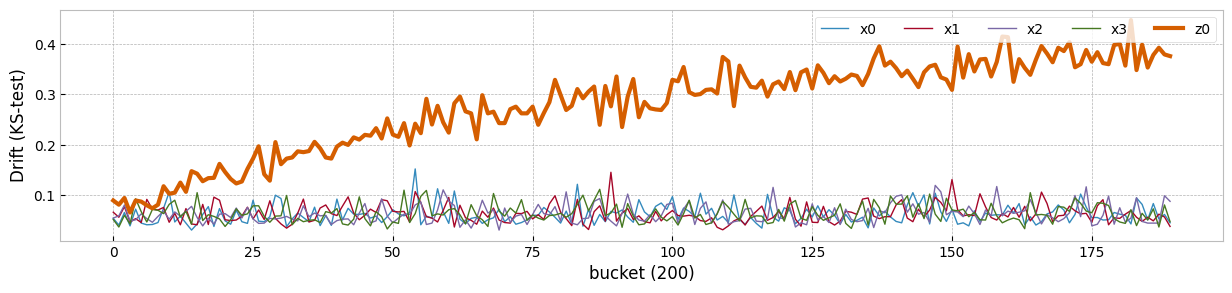

In [18]:
from tqdm import tqdm

bucket_size_array=[200]#[10,50,100,200]

######################## Normalization ############################
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_c1 = StandardScaler()
scaler_c1.fit(X[0:1800])
X = pd.DataFrame(scaler_c1.transform(X), columns=columns)

for bucket_size in bucket_size_array:
    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    #step_size = int(x.shape[0]/bucket_size)
    step_size = int((x.shape[0]-2000)/bucket_size)

    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        mi_scores = make_mi_scores(X[bk*bucket_size:bk*bucket_size+bucket_size], y[bk*bucket_size:bk*bucket_size+bucket_size], discrete_features="auto")
        ks = __ks_drift(X[0:1800].values,X[bk*bucket_size+2000:bk*bucket_size+bucket_size+2000].values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_mis['z0'].values,linewidth=3,label='z0')
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[['x0','x1','x2','x3']].values,linewidth=1,label=['x0','x1','x2','x3'])
    plt.plot(df_drf['z0'].values,linewidth=3,label='z0')
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=5)
    plt.show()

### 실험 #1
+ train:test = 1800:200
+ 최초 100개 bucket

In [ ]:
#model = model
X['Y'] = y

bucket_size=200

df_train = X[0:1800]
df_test = X[1800:2000]
ylabel = "Y"
live_set = [X[i*bucket_size+2000:i*bucket_size+bucket_size+2000] for i in range(int(X[2000:].shape[0]/bucket_size))]
target_cols = ['x0','x1','x2','x3','z0']
drop_cols = ['Y']

In [ ]:
model = RandomForestClassifier(max_depth=6).fit(df_train[target_cols].values, y[0:1800])

In [ ]:
predicted_y = model.predict(df_test[target_cols])
f1 = f1_score(df_test[drop_cols],(predicted_y > 0.5).astype(float))
print('feature 5, test_f1',f1)

In [ ]:
PPM_Test(model,df_train,df_test,ylabel,live_set[0:100],target_cols,drop_cols)

### 실험 #2
+ train:test = 2000:2000

In [ ]:
#model = model
X['Y'] = y

bucket_size=200

df_train = X[0:2000]
df_test = X[2000:4000]
ylabel = "Y"
live_set = [X[i*bucket_size+4000:i*bucket_size+bucket_size+4000] for i in range(int(X[4000:].shape[0]/bucket_size))]
target_cols = ['x0','x1','x2','x3','z0']
drop_cols = ['Y']

In [ ]:
model = RandomForestClassifier(max_depth=6).fit(df_train[target_cols].values, y[0:2000])
predicted_y = model.predict(df_test[target_cols])
f1 = f1_score(df_test[drop_cols],(predicted_y > 0.5).astype(float))
print('feature 5, test_f1',f1)
PPM_Test(model,df_train,df_test,ylabel,live_set[0:100],target_cols,drop_cols)

### 실험 #3
+ train:test = 2000:2000 (random)

In [19]:
from sklearn.model_selection import train_test_split

#model = model
X['Y'] = y

bucket_size=200

df_train, df_test, y_train, y_test = train_test_split(X[0:4000], y[0:4000], test_size=0.5,random_state=777)
#df_train = X[0:2000]
#df_test = X[2000:4000]
ylabel = "Y"
live_set = [X[i*bucket_size+4000:i*bucket_size+bucket_size+4000] for i in range(int(X[4000:].shape[0]/bucket_size))]
target_cols = ['x0','x1','x2','x3','z0']
drop_cols = ['Y']

In [20]:
df_train

,x0,x1,x2,x3,z0,Y
2668,0.261852,0.382188,0.948918,2.657438,-1.363288,1
3718,0.407237,1.665092,1.244849,1.530161,0.920891,1
1277,-2.168911,-0.484068,-1.426376,0.271544,0.944408,0
2776,1.371100,-1.751179,0.863887,1.850505,1.552686,1
764,0.817581,1.738785,1.201055,0.190111,0.026198,1
...,...,...,...,...,...,...
3671,-0.001674,-0.119799,0.293550,1.686264,-0.499206,1
2982,0.246481,-0.627001,0.117306,-1.457659,-1.796106,0
3643,0.760341,0.101382,0.820141,0.656553,2.619890,1
2863,-1.669270,1.893181,0.099027,0.458586,-0.528401,1


In [21]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=6).fit(df_train[target_cols].values, df_train[drop_cols])
predicted_y = model.predict(df_test[target_cols])
f1 = f1_score(df_test[drop_cols],(predicted_y > 0.5).astype(float))
print('feature 5, test_f1',f1)

PPM_Test(model,df_train,df_test,ylabel,live_set[0:100],target_cols,drop_cols)

feature 5, test_f1 0.878727634194831


AttributeError: ignored

### 실험 #4
+ train:blank:test = 2000:2000:2000

In [ ]:
#model = model
X['Y'] = y

bucket_size=200

df_train = X[0:2000]
df_test = X[4000:6000]
ylabel = "Y"
live_set = [X[i*bucket_size+6000:i*bucket_size+bucket_size+6000] for i in range(int(X[6000:].shape[0]/bucket_size))]
target_cols = ['x0','x1','x2','x3','z0']
drop_cols = ['Y']

In [ ]:
model = RandomForestClassifier(max_depth=6).fit(df_train[target_cols].values, y[0:2000])
predicted_y = model.predict(df_test[target_cols])
f1 = f1_score(df_test[drop_cols],(predicted_y > 0.5).astype(float))
print('feature 5, test_f1',f1)
PPM_Test(model,df_train,df_test,ylabel,live_set[0:100],target_cols,drop_cols)